# DeepCross 广告点击率预测

谷歌的DeepCross系列模型(DCN-vector, DCN-matrix, DCN-mix) 围绕解决的核心问题是三高问题。

如何实现 高效率，高表达能力 的 高阶显式特征交叉？

本范例演示使用 torchkeras.tabular.DeepCrossModel 模型 进行广告点击率预测。

有关DeepCross模型的详细理论介绍和代码讲解，参考如下eat_pytorch_in_20_days中的讲解教程：

https://github.com/lyhue1991/eat_pytorch_in_20_days/blob/master/7-6%2CDeepCross%E6%A8%A1%E5%9E%8B.ipynb


公众号**算法美食屋**后台回复关键词：torchkeras，获取本文notebook源码和所用criteo_small数据集下载链接。


In [1]:
import sys
sys.path.append('..')

## 一，准备数据

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

np.random.seed(42)


In [3]:
from sklearn.preprocessing import LabelEncoder

dfdata = pd.read_csv('criteo_small.zip',sep='\t',header=None)
dfdata.columns = ["label"] + ["I"+str(x) for x in range(1,14)] + [
    "C"+str(x) for x in range(14,40)]

target_col = 'label'
cat_cols = [x for x in dfdata.columns if x.startswith('C')]
num_cols = [x for x in dfdata.columns if x.startswith('I')]


In [4]:
dftrain_val,dftest_raw = train_test_split(dfdata,test_size=0.2,random_state=42)
dftrain_raw,dfval_raw = train_test_split(dftrain_val,test_size=0.2,random_state=42)


In [5]:
from torchkeras.tabular import TabularPreprocessor
from sklearn.preprocessing import OrdinalEncoder

#特征工程
pipe = TabularPreprocessor(cat_features = cat_cols, onehot_max_cat_num=3)
encoder = OrdinalEncoder()

dftrain = pipe.fit_transform(dftrain_raw.drop(target_col,axis=1))
dftrain[target_col] = encoder.fit_transform(
    dftrain_raw[target_col].values.reshape(-1,1)).astype(np.int32)

dfval = pipe.transform(dfval_raw.drop(target_col,axis=1))
dfval[target_col] = encoder.transform(
    dfval_raw[target_col].values.reshape(-1,1)).astype(np.int32)

dftest = pipe.transform(dftest_raw.drop(target_col,axis=1))
dftest[target_col] = encoder.transform(
    dftest_raw[target_col].values.reshape(-1,1)).astype(np.int32)


  0%|          | 0/24 [00:00<?, ?it/s]

In [6]:
from torchkeras.tabular import TabularDataset
from torch.utils.data import Dataset,DataLoader 

def get_dataset(dfdata):
    return TabularDataset(
                data = dfdata,
                task = 'binary', # regression,binary,multiclass
                target = [target_col],
                continuous_cols = pipe.get_numeric_features(),
                categorical_cols = pipe.get_embedding_features()
        )

def get_dataloader(ds,batch_size=512,num_workers=0,shuffle=False):
    dl = DataLoader(
            ds,
            batch_size=batch_size,
            shuffle=shuffle,
            num_workers=num_workers,
            pin_memory=False,
        )
    return dl 
    
ds_train = get_dataset(dftrain)
ds_val = get_dataset(dfval)
ds_test = get_dataset(dftest)

dl_train = get_dataloader(ds_train,batch_size=2048,num_workers=4,shuffle=True)
dl_val = get_dataloader(ds_val,batch_size=2048,shuffle=False)
dl_test = get_dataloader(ds_test,batch_size=2048,shuffle=False)



In [7]:
for batch in dl_train:
    break

## 二，定义模型

In [9]:
from torchkeras.tabular.models import DeepCrossConfig,DeepCrossModel

model_config = DeepCrossConfig(
    task="binary",
    input_embed_max = 32, 
    cross_type = "mix",
    cross_order = 2,
    experts_num=8,
    low_rank=16,
    mlp_layers = "64-32",
    mlp_dropout=0.10,
    stacked = False
)
config = model_config.merge_dataset_config(ds_train)

print('input_embed_max = ', config.input_embed_max)
print('\n categorical_cardinality = ',config.categorical_cardinality)


input_embed_max =  32

 categorical_cardinality =  [1000, 529, 1000, 1000, 246, 15, 1000, 502, 1000, 1000, 1000, 1000, 26, 1000, 1000, 10, 1000, 1000, 1000, 16, 15, 1000, 63, 1000]


In [10]:
net = DeepCrossModel(config = config)

#初始化参数
net.reset_weights()
net.data_aware_initialization(dl_train)



In [11]:
output = net.forward(batch)
loss = net.compute_loss(output,batch['target'])
print(loss)

tensor(0.6929, grad_fn=<AddBackward0>)


## 三，训练模型

In [12]:
from torchkeras import KerasModel 
from torchkeras.tabular import StepRunner 
KerasModel.StepRunner = StepRunner 

import torch 
from torchkeras.metrics import AUC 

optimizer = torch.optim.AdamW(net.parameters(),lr = 1e-3)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, 
#                                                steps_per_epoch=len(dl_train), epochs=20)
keras_model = KerasModel(net,
                   loss_fn=None,
                   optimizer = optimizer,
                   metrics_dict = {'auc':AUC()}
                   )


<<<<<< 🚀 mps is used >>>>>>


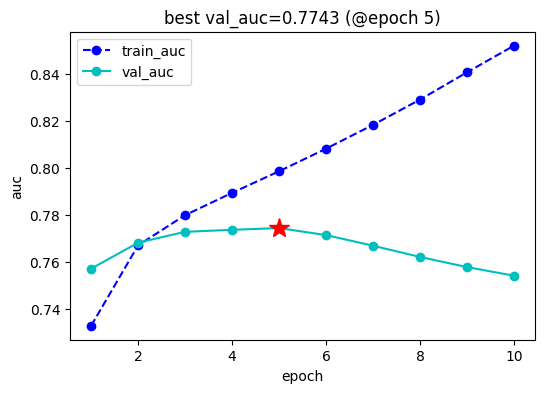

<<<<<< val_auc without improvement in 5 epoch,early stopping >>>>>> 



,epoch,train_loss,train_auc,lr,val_loss,val_auc
0,1,0.498843,0.732795,0.001,0.483020,0.757059
1,2,0.476000,0.766988,0.001,0.475342,0.768114
2,3,0.466130,0.779811,0.001,0.471723,0.772724
3,4,0.458502,0.789287,0.001,0.471544,0.773577
4,5,0.450772,0.798471,0.001,0.473855,0.774328
5,6,0.442359,0.808066,0.001,0.475346,0.771335
6,7,0.432851,0.818195,0.001,0.481294,0.766819
7,8,0.422288,0.828934,0.001,0.488921,0.762048
8,9,0.410224,0.840528,0.001,0.498291,0.757735
9,10,0.397602,0.851858,0.001,0.511527,0.754068


In [13]:
keras_model.fit(
    train_data = dl_train,
    val_data= dl_val,
    ckpt_path='checkpoint',
    epochs=30,
    patience=5,
    monitor="val_auc", 
    mode="max",
    plot = True,
    wandb = False
)

## 四，评估模型

In [ ]:
keras_model.evaluate(dl_train)

In [ ]:
keras_model.evaluate(dl_val)

In [ ]:
keras_model.evaluate(dl_test)

## 五，使用模型

In [ ]:
from tqdm import tqdm 

net,dl_test = keras_model.accelerator.prepare(net,dl_test)
net.eval()
preds = []
with torch.no_grad():
    for batch in tqdm(dl_test):
        preds.append(net.predict(batch))
    

In [ ]:
yhat_list = [yd.sigmoid().reshape(-1).tolist() for yd in preds]
yhat = []
for yd in yhat_list:
    yhat.extend(yd)

In [ ]:
dftest_raw = dftest_raw.rename(columns = {target_col: 'y'})
dftest_raw['yhat'] = yhat

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(dftest_raw['y'],dftest_raw['yhat'])

## 六，保存模型

最佳模型权重已经保存在ckpt_path = 'checkpoint'位置了。

In [ ]:
net.load_state_dict(torch.load('checkpoint'))